# Content Based Recommendation using the Descriptions

## Imports

In [ ]:
!pip install transformers
!pip3 install pickle5

     |████████████████████████████████| 2.3MB 6.8MB/s 
     |████████████████████████████████| 901kB 37.8MB/s 
     |████████████████████████████████| 3.3MB 39.2MB/s 
     |████████████████████████████████| 133kB 7.2MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219244 sha256=6c675856935d6e8f6d27b0ad776e112a45a69f32120c27eb0dad3ebff2e0d20c
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
from google.colab import drive
import pickle5 as pickle
from transformers import BertModel, BertTokenizerFast, DistilBertModel, DistilBertTokenizerFast, XLMModel, XLMTokenizer, Trainer, TrainingArguments
import torch
import multiprocessing as mp
import datetime
import os
import numpy as np
import time
import pandas as pd
import gc

In [ ]:
def save_as_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [ ]:
drive.mount('/content/drive', force_remount=True)  # use force_remount=True param after upload of new data

# file and folder names
project_drive_folder = "Master/2 - FSS 2021/Data Mining II/Data Mining Cup" 
full_project_drive_folder = "/content/drive/My Drive/{}/Data/".format(project_drive_folder)

# general
items_path = full_project_drive_folder + 'DMC-2021-Task/items.csv'
google_crawl_path = full_project_drive_folder + 'CrawledData/GoogleBooksAPI/GBooksAPI_JSONtoPandas_withImages_20210524.csv'

# summaries
encodings_path = full_project_drive_folder + 'descriptions/xlm_encodings.pkl'
embeddings_folder = full_project_drive_folder + 'descriptions/embeddings/'
embeddings_path = full_project_drive_folder + 'descriptions/xlm_embeddings.pkl'

# Amazon Data
amazon_test_path = full_project_drive_folder + 'Amazon/dmc21_amazon_test.csv'
amazon_val_path = full_project_drive_folder + 'Amazon/dmc21_amazon_validation.csv'

Mounted at /content/drive


## items.csv and Google Data

### Load & Merge

In [ ]:
items = pd.read_csv(items_path, sep='|')
google_data = pd.read_csv(google_crawl_path, sep='\t')

(72217, 7)

In [ ]:
items.info()
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78030 entries, 0 to 78029
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   itemID      78030 non-null  int64 
 1   title       78030 non-null  object
 2   author      74790 non-null  object
 3   publisher   78021 non-null  object
 4   main topic  77772 non-null  object
 5   subtopics   78029 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72217 entries, 0 to 72216
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           72217 non-null  object
 1   authors         72217 non-null  object
 2   language        72217 non-null  object
 3   description     72216 non-null  object
 4   previewLink     72217 non-null  object
 5   smallThumbnail  72217 non-null  object
 6   bigThumbnail    72217 non-null  object
dtypes: object(7)


In [ ]:
print(google_data.shape)
google_filtered = google_data.drop_duplicates(subset=['title'])
print(google_filtered.shape)
print(items.shape)
items_filtered = items.drop_duplicates(subset=['title', 'author'])
print(items_filtered.shape)

(72217, 7)
(63504, 7)
(78030, 6)
(73822, 6)


In [ ]:
duplicates = items.duplicated(subset=['title', 'author', 'publisher', 'main topic'])
print(duplicates.shape)

(78030,)


In [ ]:
items_enriched = items.merge(google_data, on='title', suffixes=['_i', '_g'])
items_enriched = items_enriched[items_enriched['description'] != 'NOT_FOUND']
items_enriched.dropna(subset=['description'], inplace=True)
items_enriched.info()
# items_enriched.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62033 entries, 0 to 69828
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          62033 non-null  int64 
 1   title           62033 non-null  object
 2   author          61477 non-null  object
 3   publisher       62032 non-null  object
 4   main topic      61915 non-null  object
 5   subtopics       62033 non-null  object
 6   authors         62033 non-null  object
 7   language        62033 non-null  object
 8   description     62033 non-null  object
 9   previewLink     62033 non-null  object
 10  smallThumbnail  62033 non-null  object
 11  bigThumbnail    62033 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.2+ MB


In [ ]:
items_enriched.value_counts(subset=['itemID'])

itemID
11654     23
16007     23
42664     23
59542     23
44391     23
          ..
50063      1
50061      1
50059      1
50056      1
6          1
Length: 44836, dtype: int64

In [ ]:
def get_index_from_itemid(dataframe, item_id):
  try:
    return dataframe['itemID'].loc[lambda x: x==item_id].index[0]
  except Exception:
    return np.nan

# get_index_from_itemid(62540)

### Statistics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f2313fcd0>]],
      dtype=object)

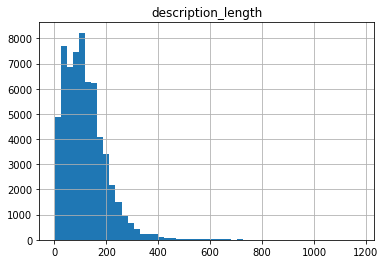

In [ ]:
items_enriched['description_length'] = items_enriched.apply(lambda row: len(row['description'].split()), axis=1)
items_enriched.describe()
items_enriched.hist(column=['description_length'], bins=50)

In [ ]:
items_enriched[items_enriched['description_length'] > 512].shape

(183, 13)

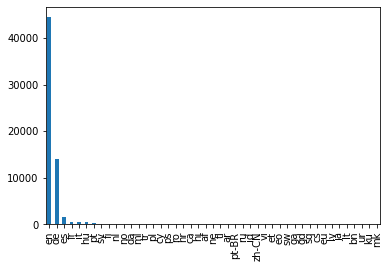

In [ ]:
items_enriched['language'].value_counts().plot(kind='bar')

FM       5783
YFB      4118
FL       4047
YFA      3883
YFH      3499
         ... 
UDBS        1
YPCK9       1
XAB         1
YBLM        1
JBCT1       1
Name: main topic, Length: 493, dtype: int64


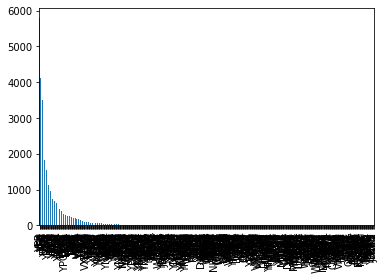

In [ ]:
print(items_enriched['main topic'].value_counts())
items_enriched['main topic'].value_counts().plot(kind='bar')

## Compute Embeddings

### Encode

In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-xnli15-1024')

Some weights of the model checkpoint at xlm-mlm-ende-1024 were not used when initializing XLMModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
encodings = tokenizer.batch_encode_plus(list(items_enriched['description'].values), 
                                        truncation=True, padding="max_length", return_tensors="pt")
save_as_pickle(encodings, encodings_path)

In [ ]:
encodings = load_pickle(encodings_path)

In [ ]:
print(encodings['input_ids'].size())

torch.Size([62033, 512])


### Apply Model

In [ ]:
# model = BertModel.from_pretrained('bert-base-uncased')
model = XLMModel.from_pretrained('xlm-mlm-ende-1024')

Some weights of the model checkpoint at xlm-mlm-ende-1024 were not used when initializing XLMModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, boundaries=None):
    if boundaries is not None:
      self.encodings = {key: val[boundaries[0]: boundaries[1]] for key, val in encodings.items()}
    else:
      self.encodings = encodings

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return item

  def __len__(self):
      return len(self.encodings['input_ids'])

# dataset = Dataset(encodings, (0, 1000))
# dataset = Dataset(encodings)
# print(len(dataset))
# dataset.__getitem__(10)

In [ ]:
trainer = Trainer(
    model = model
)

In [ ]:
def get_embeddings(dataset):
  prediction_output = trainer.predict(dataset)
  predictions = prediction_output.predictions
  results = predictions[:,0,:]
  del predictions
  del prediction_output
  torch.cuda.empty_cache()
  gc.collect()
  return results

In [ ]:
subset_size = 1000

In [ ]:
for i in range(1000, len(encodings['input_ids']), subset_size):
  print(i)
  sub_dataset = Dataset(encodings, (i-subset_size, i))
  embedding_array = get_embeddings(sub_dataset)
  path = full_project_drive_folder + f'descriptions/embeddings/{i-subset_size}-{i}.pkl'
  save_as_pickle(embedding_array, path)
  print('saved', path)
  del sub_dataset
  del embedding_array
  torch.cuda.empty_cache()
  gc.collect()

In [ ]:
# rests
lower = 62000
upper = len(encodings['input_ids'])
sub_dataset = Dataset(encodings, (lower, upper))
embedding_array = get_embeddings(sub_dataset)
path = full_project_drive_folder + f'descriptions/embeddings/{lower}-{upper}.pkl'
save_as_pickle(embedding_array, path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


### Combine Results

In [ ]:
from os import listdir
from os.path import join

embedding_arrays = [load_pickle(join(embeddings_folder, f)) for f in listdir(embeddings_folder)]
embeddings = np.concatenate(embedding_arrays)
save_as_pickle(embeddings, embeddings_path)

In [ ]:
embeddings = load_pickle(embeddings_path)

In [ ]:
embeddings.shape

(62033, 1024)

## Prepare Amazon Evluation Data

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
amazon_test = pd.read_csv(amazon_test_path)
amazon_val = pd.read_csv(amazon_val_path)
amazon_test['items_enriched_index'] = amazon_test.apply(lambda row: get_index_from_itemid(items_enriched, row['itemID']), axis=1)
print(amazon_test.shape)
# items_enriched_index is null if item is not in enriched data set (which contains descriptions)
amazon_test.info()

(233, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   itemID                233 non-null    int64  
 1   rec1_ID               162 non-null    object 
 2   rec2_ID               157 non-null    object 
 3   rec3_ID               119 non-null    object 
 4   rec4_ID               117 non-null    object 
 5   rec5_ID               111 non-null    object 
 6   rec6_ID               96 non-null     object 
 7   rec7_ID               96 non-null     object 
 8   items_enriched_index  139 non-null    float64
dtypes: float64(1), int64(1), object(7)
memory usage: 16.5+ KB


In [ ]:
for idx, test_row in amazon_test.iterrows():
  if idx == 1:
    break
  if not np.isnan(test_row['items_enriched_index']):
    cosine_similarity_matrix = cosine_similarity(embeddings[int(test_row['items_enriched_index']),:].reshape(1, -1), embeddings)
    print(cosine_similarity_matrix.shape)
    item_sim_pairs = [(items_enriched.iloc[idx]['itemID'], sim) for idx, sim in enumerate(cosine_similarity_matrix[0])]
    item_sim_pairs.sort(key=lambda pair: pair[1], reverse=True)
    print(item_sim_pairs)

(1, 62033)
[(44545, 1.0), (44545, 1.0), (44545, 1.0), (44545, 1.0), (44545, 1.0), (47450, 1.0), (47450, 1.0), (47450, 1.0), (47450, 1.0), (47450, 1.0), (14005, 1.0), (14005, 1.0), (14005, 1.0), (14005, 1.0), (14005, 1.0), (77558, 1.0), (77558, 1.0), (77558, 1.0), (77558, 1.0), (77558, 1.0), (14135, 1.0), (14135, 1.0), (14135, 1.0), (14135, 1.0), (14135, 1.0), (76591, 0.98171747), (41743, 0.9796907), (28515, 0.9773381), (29217, 0.9769711), (48255, 0.9769539), (65860, 0.9767077), (62044, 0.976579), (55619, 0.976579), (9790, 0.97639084), (45324, 0.9762908), (76475, 0.97591746), (73132, 0.97591746), (54234, 0.97591746), (23234, 0.97525936), (46824, 0.9752461), (67860, 0.97486055), (67860, 0.97486055), (14673, 0.97486055), (14673, 0.97486055), (27708, 0.9745662), (27708, 0.9745662), (27708, 0.9745662), (76425, 0.9745662), (76425, 0.9745662), (76425, 0.9745662), (53983, 0.9745662), (53983, 0.9745662), (53983, 0.9745662), (18787, 0.9743058), (7668, 0.97423905), (1187, 0.97353196), (72837, 0.9